In [217]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import geocoder
import folium
from geopy.geocoders import Nominatim
import json
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statistics import mean
from geopy import distance
from sklearn import preprocessing
from pylab import rcParams

In [218]:
CLIENT_ID = 'IQOHIX5GIH4TJVTPELPKXYUXILVRPHH3VBL3ONNPOFDBJBME' # your Foursquare ID
CLIENT_SECRET = 'IWK3HJPQS34VKD4ZOGSUPBMVEZCAU05YBG1QVSHUTSXLQERH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value
ACCESS_TOKEN = '1NT1T43NUOVRMILAWEUUNTM3X0GE2RZVULBEVIBHIGGGLMR3' # your FourSquare Access Token

In [219]:
address = 'Charlotte, NC'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
uptown_coords = (latitude, longitude)
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Charlotte are 35.2272086, -80.8430827.


In [220]:
search_query = ""
#Foursquare API category IDs
bus_stop = "52f2ab2ebcbc57f1066b8b4f"
light_rail = "4bf58dd8d48988d1fc931735"
metro = "4bf58dd8d48988d1fd931735"
apartments = "4d954b06a243a5684965b473"

In [221]:
def getNearbyVenues(names, latitudes, longitudes, venue_type, radius=32000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            venue_type, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [222]:
charlotte_apartments = getNearbyVenues(["Charlotte, NC"], [latitude], [longitude], apartments)
charlotte_apartments.head()

Charlotte, NC


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Charlotte, NC",35.227209,-80.843083,Gramercy Square at Ayrsley,35.133185,-80.933273,Residential Building (Apartment / Condo)
1,"Charlotte, NC",35.227209,-80.843083,Strawberry Hills Apartments,35.160116,-80.794209,Residential Building (Apartment / Condo)
2,"Charlotte, NC",35.227209,-80.843083,Charlotte Mecklenburg Library - Plaza Midwood,35.220607,-80.811042,Residential Building (Apartment / Condo)
3,"Charlotte, NC",35.227209,-80.843083,Spectrum South End Apartments,35.207990,-80.864252,Residential Building (Apartment / Condo)
4,"Charlotte, NC",35.227209,-80.843083,Wesley Village Apartments,35.232649,-80.870399,Residential Building (Apartment / Condo)


In [223]:
charlotte_light_rail = getNearbyVenues(["Charlotte, NC"], [latitude], [longitude], light_rail)
charlotte_light_rail.head()

Charlotte, NC


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Charlotte, NC",35.227209,-80.843083,LYNX 3rd Street/Convention Center Station,35.223776,-80.843183,Light Rail Station
1,"Charlotte, NC",35.227209,-80.843083,LYNX Carson Station,35.218841,-80.850823,Light Rail Station
2,"Charlotte, NC",35.227209,-80.843083,LYNX CTC/Arena Station,35.225376,-80.840982,Light Rail Station
3,"Charlotte, NC",35.227209,-80.843083,LYNX 7th Street Station,35.227435,-80.838098,Light Rail Station
4,"Charlotte, NC",35.227209,-80.843083,LYNX Stonewall Station,35.221496,-80.846946,Light Rail Station


In [224]:
charlotte_bus_stops = getNearbyVenues(["Charlotte, NC"], [latitude], [longitude], bus_stop)
charlotte_bus_stops.drop([22],inplace=True) #Dropping one entry that is a parging garage
charlotte_bus_stops.head()

Charlotte, NC


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Charlotte, NC",35.227209,-80.843083,Bus Stop ( College & 6th),35.227725,-80.839744,Bus Stop
1,"Charlotte, NC",35.227209,-80.843083,Holiday Bus,35.216976,-80.838005,Bus Stop
2,"Charlotte, NC",35.227209,-80.843083,CATS 9 Bus,35.218303,-80.831739,Bus Stop
3,"Charlotte, NC",35.227209,-80.843083,Bus Stop (Hawthorne and Elizabeth),35.213252,-80.826114,Bus Stop
4,"Charlotte, NC",35.227209,-80.843083,7th and Hawthorne,35.215409,-80.821805,Bus Stop


In [227]:
# create map of Charlotte using latitude and longitude values
map_Charlotte = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, city, venue in zip(charlotte_apartments['Venue Latitude'], charlotte_apartments['Venue Longitude'], charlotte_apartments['Neighbourhood'], charlotte_apartments['Venue']):
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Charlotte)

for lat, lng, city, venue in zip(charlotte_light_rail['Venue Latitude'], charlotte_light_rail['Venue Longitude'], charlotte_light_rail['Neighbourhood'], charlotte_light_rail['Venue']):
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Charlotte)  

for lat, lng, city, venue in zip(charlotte_bus_stops['Venue Latitude'], charlotte_bus_stops['Venue Longitude'], charlotte_bus_stops['Neighbourhood'], charlotte_bus_stops['Venue']):
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Charlotte)  

label = '{}, {}'.format("venue", city)
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=7,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='yellow',
    fill_opacity=0.5,
    opacity = 1,
    parse_html=False).add_to(map_Charlotte)
    
map_Charlotte

![jpg](images/Charlotte.JPG)

In [228]:
distances_to_uptown = []
closest_distances_to_light_rail = []
closest_distances_to_bus_stop = []
light_rails_within_1km = []
bus_stops_within_1km = []
for apartment_index, apartment_row in charlotte_apartments.iterrows():
    local_light_rail_distances = []
    local_bus_stop_distances = []
    apartment_coords = (apartment_row['Venue Latitude'], apartment_row['Venue Longitude'])
    for light_rail_index, light_rail_row in charlotte_light_rail.iterrows():
        light_rail_coords = light_rail_row['Venue Latitude'], light_rail_row['Venue Longitude']
        local_light_rail_distances.append(distance.distance(apartment_coords, light_rail_coords))
    light_rails_within_1km.append(sum(1 for i in local_light_rail_distances if i < 1))
    closest_distances_to_light_rail.append(min(local_light_rail_distances).km)
    for bus_stop_index, bus_stop_row in charlotte_bus_stops.iterrows():
        bus_stop_coords = bus_stop_row['Venue Latitude'], bus_stop_row['Venue Longitude']
        local_bus_stop_distances.append(distance.distance(apartment_coords, bus_stop_coords))
    bus_stops_within_1km.append(sum(1 for i in local_bus_stop_distances if i < 1))
    closest_distances_to_bus_stop.append(min(local_bus_stop_distances).km)
    distances_to_uptown.append(distance.distance(apartment_coords, uptown_coords).km)
charlotte_apartments['Distance to Uptown'] = distances_to_uptown
charlotte_apartments['Distance to Nearest Light Rail Station'] = closest_distances_to_light_rail
charlotte_apartments['Distance to Nearest Bus Stop'] = closest_distances_to_bus_stop

In [229]:
print("The mean number of light rail stations within 1km of an apartment is {}".format(mean(light_rails_within_1km)))
print("The mean number of bus stops within 1km of an apartment is {}".format(mean(bus_stops_within_1km)))

The mean number of light rail stations within 1km of an apartment is 1.59
The mean number of bus stops within 1km of an apartment is 0.51


In [230]:
charlotte_apartments.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop
0,"Charlotte, NC",35.227209,-80.843083,Gramercy Square at Ayrsley,35.133185,-80.933273,Residential Building (Apartment / Condo),13.277901,4.910963,7.577319
1,"Charlotte, NC",35.227209,-80.843083,Strawberry Hills Apartments,35.160116,-80.794209,Residential Building (Apartment / Condo),8.672787,6.422971,3.534587
2,"Charlotte, NC",35.227209,-80.843083,Charlotte Mecklenburg Library - Plaza Midwood,35.220607,-80.811042,Residential Building (Apartment / Condo),3.007500,0.677424,1.137022
3,"Charlotte, NC",35.227209,-80.843083,Spectrum South End Apartments,35.207990,-80.864252,Residential Building (Apartment / Condo),2.874219,0.639925,2.589448
4,"Charlotte, NC",35.227209,-80.843083,Wesley Village Apartments,35.232649,-80.870399,Residential Building (Apartment / Condo),2.558836,2.330018,2.843520


In [231]:
apartments_for_clustering = charlotte_apartments.drop(columns=["Neighbourhood", "Neighbourhood Latitude", "Neighbourhood Longitude", "Venue", "Venue Latitude", "Venue Longitude", "Venue Category"])
apartments_for_clustering

,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop
0,13.277901,4.910963,7.577319
1,8.672787,6.422971,3.534587
2,3.007500,0.677424,1.137022
3,2.874219,0.639925,2.589448
4,2.558836,2.330018,2.843520
...,...,...,...
95,13.473772,5.328165,7.943803
96,13.989855,11.147284,6.820542
97,14.040949,2.519374,1.403937
98,14.273851,1.427253,2.480184


In [232]:
print("Mean distance from an apartment to uptown Charlotte is {:.3}km".format(mean(apartments_for_clustering["Distance to Uptown"])))
print("Mean distance from an apartment to the nearest light rail station is {:.3}km".format(mean(apartments_for_clustering["Distance to Nearest Light Rail Station"])))
print("Mean distance from an apartment to the nearest bus stop is {:.3}km".format(mean(apartments_for_clustering["Distance to Nearest Bus Stop"])))

Mean distance from an apartment to uptown Charlotte is 6.46km
Mean distance from an apartment to the nearest light rail station is 2.25km
Mean distance from an apartment to the nearest bus stop is 2.46km


In [233]:
normalized_uptown = preprocessing.normalize([apartments_for_clustering["Distance to Uptown"]])
normalized_light_rail = preprocessing.normalize([apartments_for_clustering["Distance to Nearest Light Rail Station"]])
normalized_bus_stop = preprocessing.normalize([apartments_for_clustering["Distance to Nearest Bus Stop"]])
apartments_for_clustering["Distance to Uptown"] = normalized_uptown[0]
apartments_for_clustering["Distance to Nearest Light Rail Station"] = normalized_light_rail[0]
apartments_for_clustering["Distance to Nearest Bus Stop"] = normalized_bus_stop[0]

In [234]:
apartments_for_clustering

,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop
0,0.163089,0.151472,0.237011
1,0.106526,0.198107,0.110558
2,0.036940,0.020894,0.035565
3,0.035303,0.019738,0.080995
4,0.031430,0.071866,0.088942
...,...,...,...
95,0.165495,0.164339,0.248474
96,0.171834,0.343822,0.213339
97,0.172462,0.077706,0.043914
98,0.175322,0.044022,0.077578


In [235]:
mms = MinMaxScaler()
mms.fit(apartments_for_clustering)
data_transformed = mms.transform(apartments_for_clustering)

In [236]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(apartments_for_clustering)
    Sum_of_squared_distances.append(km.inertia_)

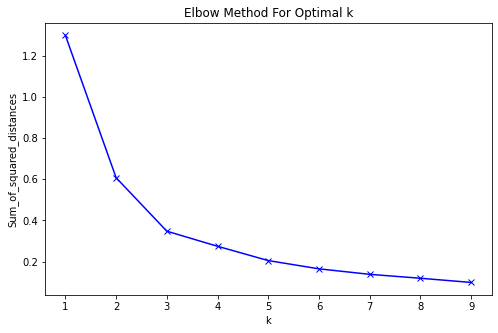

In [237]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [238]:
# set number of clusters
kclusters = 3
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(apartments_for_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2])

In [239]:
charlotte_apartments['Cluster Labels'] = kmeans.labels_
charlotte_apartments

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop,Cluster Labels
0,"Charlotte, NC",35.227209,-80.843083,Gramercy Square at Ayrsley,35.133185,-80.933273,Residential Building (Apartment / Condo),13.277901,4.910963,7.577319,1
1,"Charlotte, NC",35.227209,-80.843083,Strawberry Hills Apartments,35.160116,-80.794209,Residential Building (Apartment / Condo),8.672787,6.422971,3.534587,1
2,"Charlotte, NC",35.227209,-80.843083,Charlotte Mecklenburg Library - Plaza Midwood,35.220607,-80.811042,Residential Building (Apartment / Condo),3.007500,0.677424,1.137022,0
3,"Charlotte, NC",35.227209,-80.843083,Spectrum South End Apartments,35.207990,-80.864252,Residential Building (Apartment / Condo),2.874219,0.639925,2.589448,0
4,"Charlotte, NC",35.227209,-80.843083,Wesley Village Apartments,35.232649,-80.870399,Residential Building (Apartment / Condo),2.558836,2.330018,2.843520,0
...,...,...,...,...,...,...,...,...,...,...,...
95,"Charlotte, NC",35.227209,-80.843083,MAA Ayrsley (Colonial Grand at Ayrsley),35.133919,-80.937792,Residential Building (Apartment / Condo),13.473772,5.328165,7.943803,1
96,"Charlotte, NC",35.227209,-80.843083,Madison Square at Northlake,35.352723,-80.857837,Residential Building (Apartment / Condo),13.989855,11.147284,6.820542,1
97,"Charlotte, NC",35.227209,-80.843083,Galleria Village Apartments,35.136453,-80.735644,Residential Building (Apartment / Condo),14.040949,2.519374,1.403937,2
98,"Charlotte, NC",35.227209,-80.843083,Thornberry Apartments,35.324155,-80.739942,Residential Building (Apartment / Condo),14.273851,1.427253,2.480184,2


In [240]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ["green", "red", "blue"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(charlotte_apartments['Venue Latitude'], charlotte_apartments['Venue Longitude'], charlotte_apartments['Venue'], charlotte_apartments['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lng, city, venue in zip(charlotte_light_rail['Venue Latitude'], charlotte_light_rail['Venue Longitude'], charlotte_light_rail['Neighbourhood'], charlotte_light_rail['Venue']):
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.5,
        opacity= 0.5, 
        parse_html=False).add_to(map_clusters)  

for lat, lng, city, venue in zip(charlotte_bus_stops['Venue Latitude'], charlotte_bus_stops['Venue Longitude'], charlotte_bus_stops['Neighbourhood'], charlotte_bus_stops['Venue']):
    label = '{}, {}'.format(venue, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.5,
        opacity = 0.5,
        parse_html=False).add_to(map_clusters)  

label = '{}, {}'.format("venue", city)
label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    color='yellow',
    fill=True,
    fill_color='yellow',
    fill_opacity=0.5,
    opacity = 1,
    parse_html=False).add_to(map_clusters)

map_clusters

![jpg](images/Charlotte_clustered.JPG)

In [241]:
avg_dist_to_uptown = []
avg_dist_to_light_rail = []
avg_dist_to_bus_stop = []
for i in range(3):
    avg_dist_to_uptown.append(mean(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == i]["Distance to Uptown"]))
    avg_dist_to_light_rail.append(mean(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == i]["Distance to Nearest Light Rail Station"]))
    avg_dist_to_bus_stop.append(mean(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == i]["Distance to Nearest Bus Stop"]))

In [242]:
charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 2].shape

(33, 11)

In [243]:
charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 2]["Distance to Nearest Bus Stop"].shape[0]

33

In [244]:
cluster0 = [avg_dist_to_uptown[0], avg_dist_to_light_rail[0], avg_dist_to_bus_stop[0]]
cluster1 = [avg_dist_to_uptown[1], avg_dist_to_light_rail[1], avg_dist_to_bus_stop[1]]
cluster2 = [avg_dist_to_uptown[2], avg_dist_to_light_rail[2], avg_dist_to_bus_stop[2]]
print("Out of {} apartments in Cluster 0:\nAverage distance to uptown: {:.3}km\nAverage distance to the nearest light rail station: {:.3}km\nAverage distance to the nearest bus stop: {:.3}km\n\n".format(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 0].shape[0], cluster0[0], cluster0[1], cluster0[2]))
print("Out of {} apartments in Cluster 1:\nAverage distance to uptown: {:.3}km\nAverage distance to the nearest light rail station: {:.3}km\nAverage distance to the nearest bus stop: {:.3}km\n\n".format(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 1].shape[0], cluster1[0], cluster1[1], cluster1[2]))
print("Out of {} apartments in Cluster 2:\nAverage distance to uptown: {:.3}km\nAverage distance to the nearest light rail station: {:.3}km\nAverage distance to the nearest bus stop: {:.3}km\n\n".format(charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 2].shape[0], cluster2[0], cluster2[1], cluster2[2]))

Out of 54 apartments in Cluster 0:
Average distance to uptown: 2.26km
Average distance to the nearest light rail station: 0.826km
Average distance to the nearest bus stop: 1.3km


Out of 13 apartments in Cluster 1:
Average distance to uptown: 12.2km
Average distance to the nearest light rail station: 6.66km
Average distance to the nearest bus stop: 6.5km


Out of 33 apartments in Cluster 2:
Average distance to uptown: 11.1km
Average distance to the nearest light rail station: 2.83km
Average distance to the nearest bus stop: 2.76km




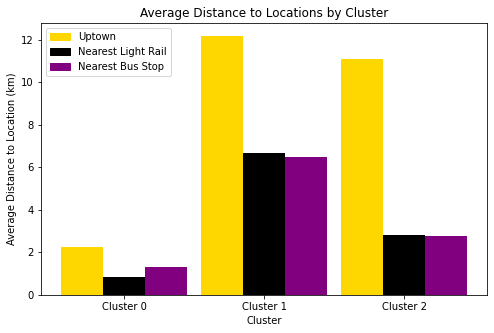

In [245]:
rcParams['figure.figsize'] = 8, 5
ind = np.arange(3)
width = 0.3
fig, ax = plt.subplots()
ax.set_ylabel('Average Distance to Location (km)')
ax.set_xlabel('Cluster')
ax.set_title("Average Distance to Locations by Cluster")
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(("Cluster 0", "Cluster 1", "Cluster 2"))
uptown_plot = plt.bar(ind, np.asarray(avg_dist_to_uptown), width, color='gold')
light_rail_plot = plt.bar(ind + width, avg_dist_to_light_rail, width, color='black')
bus_stop_plot = plt.bar(ind + 2* width, avg_dist_to_bus_stop, width, color='purple')
colors = {'Uptown':'gold', 'Nearest Light Rail':'black', 'Nearest Bus Stop':'purple'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='upper left')
plt.show()

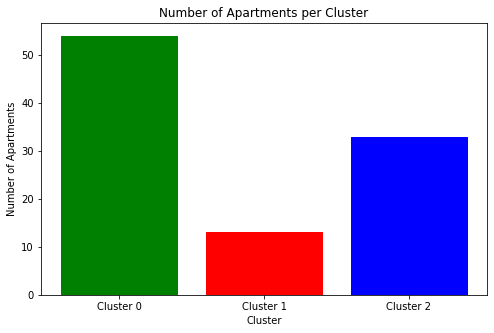

In [246]:
ind = np.arange(3)
width = 0
fig, ax = plt.subplots()
ax.set_ylabel('Number of Apartments')
ax.set_xlabel('Cluster')
ax.set_title("Number of Apartments per Cluster")
ax.set_xticks(ind + 2 * width / 2)
ax.set_xticklabels(("Cluster 0", "Cluster 1", "Cluster 2"))
my_plot = plt.bar(ind, [charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 0].shape[0], charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 1].shape[0], charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 2].shape[0]])
my_plot[0].set_color('g')
my_plot[1].set_color('r')
my_plot[2].set_color('b')
plt.show()

In [247]:
#display the members of each cluster
charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 0]

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop,Cluster Labels
2,"Charlotte, NC",35.227209,-80.843083,Charlotte Mecklenburg Library - Plaza Midwood,35.220607,-80.811042,Residential Building (Apartment / Condo),3.007500,0.677424,1.137022,0
3,"Charlotte, NC",35.227209,-80.843083,Spectrum South End Apartments,35.207990,-80.864252,Residential Building (Apartment / Condo),2.874219,0.639925,2.589448,0
4,"Charlotte, NC",35.227209,-80.843083,Wesley Village Apartments,35.232649,-80.870399,Residential Building (Apartment / Condo),2.558836,2.330018,2.843520,0
5,"Charlotte, NC",35.227209,-80.843083,The Vue,35.230914,-80.844845,Residential Building (Apartment / Condo),0.441268,0.707942,0.583776,0
6,"Charlotte, NC",35.227209,-80.843083,The Avenue,35.229257,-80.842180,Residential Building (Apartment / Condo),0.241631,0.423006,0.279419,0
7,"Charlotte, NC",35.227209,-80.843083,Ascent Uptown,35.227472,-80.847087,Residential Building (Apartment / Condo),0.365701,0.542658,0.669060,0
8,"Charlotte, NC",35.227209,-80.843083,Circa Uptown Apartments,35.229461,-80.846424,Residential Building (Apartment / Condo),0.393664,0.671472,0.637868,0
9,"Charlotte, NC",35.227209,-80.843083,400 North Church,35.230247,-80.840666,Residential Building (Apartment / Condo),0.402493,0.389744,0.292058,0
10,"Charlotte, NC",35.227209,-80.843083,The Mint Apartments,35.229812,-80.846445,Residential Building (Apartment / Condo),0.420852,0.699701,0.652494,0
11,"Charlotte, NC",35.227209,-80.843083,The VUE Charlotte,35.231109,-80.844911,Residential Building (Apartment / Condo),0.463598,0.729711,0.601810,0


In [248]:
charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 1]

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop,Cluster Labels
0,"Charlotte, NC",35.227209,-80.843083,Gramercy Square at Ayrsley,35.133185,-80.933273,Residential Building (Apartment / Condo),13.277901,4.910963,7.577319,1
1,"Charlotte, NC",35.227209,-80.843083,Strawberry Hills Apartments,35.160116,-80.794209,Residential Building (Apartment / Condo),8.672787,6.422971,3.534587,1
67,"Charlotte, NC",35.227209,-80.843083,Courtney Oaks Apartments,35.161901,-80.919109,Residential Building (Apartment / Condo),10.021810,3.791259,6.288819,1
68,"Charlotte, NC",35.227209,-80.843083,Hideaway Lake Luxury Apartments,35.162354,-80.922546,Residential Building (Apartment / Condo),10.205070,4.103028,6.588354,1
79,"Charlotte, NC",35.227209,-80.843083,Proximity Northlake,35.334783,-80.854767,Residential Building (Apartment / Condo),11.982168,9.981643,7.466182,1
81,"Charlotte, NC",35.227209,-80.843083,Bexley Creekside,35.331195,-80.801368,Residential Building (Apartment / Condo),12.144996,5.547981,4.779999,1
83,"Charlotte, NC",35.227209,-80.843083,Brookstone Apts,35.331645,-80.795941,Residential Building (Apartment / Condo),12.355038,5.160371,4.618533,1
87,"Charlotte, NC",35.227209,-80.843083,Century Northlake,35.341134,-80.855712,Residential Building (Apartment / Condo),12.691677,10.369314,7.168874,1
88,"Charlotte, NC",35.227209,-80.843083,LGI Homes - The Reserve at Canyon Hills,35.239879,-80.700931,Residential Building (Apartment / Condo),13.015930,7.052769,8.451294,1
92,"Charlotte, NC",35.227209,-80.843083,Victoria Park Apartment Homes,35.180795,-80.710334,Residential Building (Apartment / Condo),13.139278,7.121331,4.884103,1


In [249]:
charlotte_apartments.loc[charlotte_apartments['Cluster Labels'] == 2]

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Distance to Uptown,Distance to Nearest Light Rail Station,Distance to Nearest Bus Stop,Cluster Labels
53,"Charlotte, NC",35.227209,-80.843083,Courtney Ridge Apartments,35.183449,-80.899179,Residential Building (Apartment / Condo),7.047150,1.955846,4.539531,2
55,"Charlotte, NC",35.227209,-80.843083,Sterling Morrison Apartments,35.157385,-80.825179,Residential Building (Apartment / Condo),7.916293,4.779939,0.839142,2
56,"Charlotte, NC",35.227209,-80.843083,CityPark View Leasing Office,35.183407,-80.914530,Residential Building (Apartment / Condo),8.120493,3.268825,5.769929,2
58,"Charlotte, NC",35.227209,-80.843083,CityPark View,35.182585,-80.914905,Residential Building (Apartment / Condo),8.202614,3.279352,5.834678,2
59,"Charlotte, NC",35.227209,-80.843083,Piedmont Row,35.152883,-80.839933,Residential Building (Apartment / Condo),8.250976,3.411355,0.750979,2
61,"Charlotte, NC",35.227209,-80.843083,Ansley Falls Apartments,35.162726,-80.897972,Residential Building (Apartment / Condo),8.727419,1.863765,4.386738,2
62,"Charlotte, NC",35.227209,-80.843083,Tyvola Center Apartment Homes,35.162727,-80.905999,Residential Building (Apartment / Condo),9.165671,2.594994,5.099459,2
63,"Charlotte, NC",35.227209,-80.843083,Madison Southpark Apartment Homes,35.145960,-80.816940,Residential Building (Apartment / Condo),9.323228,5.531416,1.510832,2
64,"Charlotte, NC",35.227209,-80.843083,Sharon Towers Retirement Community,35.142976,-80.835243,Residential Building (Apartment / Condo),9.372336,3.831116,1.059490,2
65,"Charlotte, NC",35.227209,-80.843083,Ashford Place Apartments,35.147869,-80.883445,Residential Building (Apartment / Condo),9.539021,0.796952,3.412615,2
